# Dropout and Normalisation

## Dropout
A dropout layer helps prevent overfitting. It does this by randomly dropping neurons on training runs. This essentially creates an ensemble, preventing the network from learning spurious patterns - much the same way as random forests work.

## Batch Normalisation
It is a good idea to normalise the input data to a model along a common scale. This is because SGD shifts the network weights depending on how large the activation (output from a neuron) is. It turns out this concept also applies to data inside the network. We can apply batch normalisation to (before/after) layers in the network. This typically makes training faster and can be a magic brushstroke to help 'fix' a training run.

/Users/natedev/repos/machine-learning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Input shape: [18]
Epoch 1/50


/Users/natedev/repos/machine-learning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3654 - val_loss: 0.2211
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2423 - val_loss: 0.2182
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2224 - val_loss: 0.2144
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2160 - val_loss: 0.2087
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2100 - val_loss: 0.2099
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2061 - val_loss: 0.2088
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2049 - val_loss: 0.2089
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2010 - val_loss: 0.2050
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2008 - val_loss: 0.2041
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2006 - val_loss: 0.2035
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1979 - val_loss: 0.2028
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1967 - val_loss: 0.2019


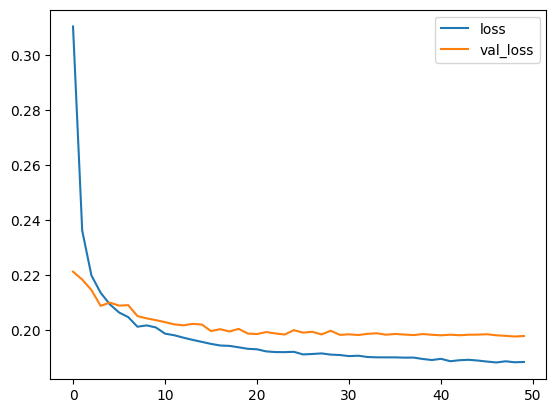

In [1]:
# Dropouts
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# Load data create a model and plot the training
spotify = pd.read_csv('./data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3), # Add the droputs here
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3), # And here. 0.3 (30%) is quite standard
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

/Users/natedev/repos/machine-learning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: nan


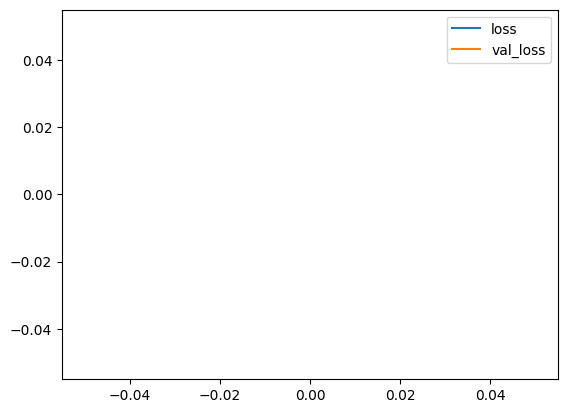

In [2]:
# Dropout
import pandas as pd

concrete = pd.read_csv('./data/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

This model fails to train as the data is not normalised.
However, if we add some normalisation:

/Users/natedev/repos/machine-learning/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Minimum Validation Loss: 4.0913


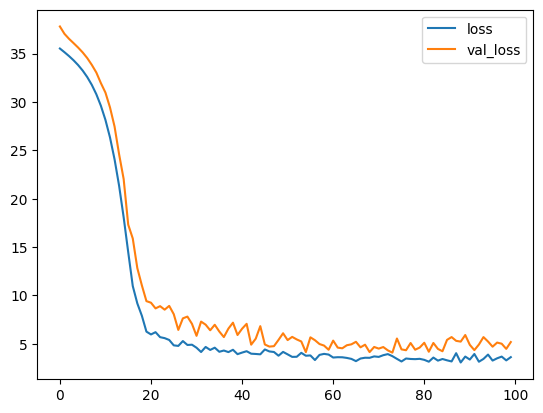

In [3]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

We can now see the model trains, and has quite a good (low) loss!